
# No Smoke Max Fall Isopleth with Photon Flux

This notebook loads the No Smoke Max Fall dataset, enriches each sample with photon flux data from the Synoptic/MesoWest API (station `QHW` – Hawthorne), and renders an ozone isopleth with data points colored by how far their photon flux deviates from the seasonal mean.


In [9]:

import os
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from scipy.interpolate import LSQBivariateSpline

plt.style.use('seaborn-v0_8')
sns.set_context('talk')
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

MESOWEST_TOKEN = os.getenv("MESOWEST_TOKEN")
if not MESOWEST_TOKEN:
    raise ValueError('Please set the MESOWEST_TOKEN environment variable before running this notebook.')

STATION_ID = 'QHW'  # Hawthorne

# Radiation metric to drive downstream plots ('uv' or 'solar')
ACTIVE_RADIATION = 'solar'

RADIATION_CONFIG = {
    'uv': {
        'value_col': 'uv_index',
        'delta_col': 'uv_index_delta',
        'display_name': 'UV index (unitless)'
    },
    'solar': {
        'value_col': 'solar_radiation_w_m2',
        'delta_col': 'solar_radiation_delta',
        'display_name': 'Solar radiation (W/m^2)'
    }
}

if ACTIVE_RADIATION not in RADIATION_CONFIG:
    raise ValueError(f"Unsupported ACTIVE_RADIATION '{ACTIVE_RADIATION}'. Choose from {list(RADIATION_CONFIG)}.")

ACTIVE_RADIATION_CONFIG = RADIATION_CONFIG[ACTIVE_RADIATION]


In [10]:
data_path = Path('../data/utah/nosmoke/No_Smoke_Max_Fall.csv')
no_smoke_df = pd.read_csv(data_path, parse_dates=['dt'])
no_smoke_df.sort_values('dt', inplace=True)
no_smoke_df['dt_hour'] = no_smoke_df['dt'].dt.floor('H')

print(f"Loaded {len(no_smoke_df)} observations spanning {no_smoke_df['dt'].min()} to {no_smoke_df['dt'].max()}.")
no_smoke_df.head()

Loaded 162 observations spanning 2021-09-01 15:00:00 to 2023-09-30 10:00:00.


,NOx,VOC,Ozone,dt,dt_hour
0,4.3,14.1395,80.0,2021-09-01 15:00:00,2021-09-01 15:00:00
1,5.2,27.2669,58.0,2021-09-10 16:00:00,2021-09-10 16:00:00
2,3.2,21.5934,63.0,2021-09-25 15:00:00,2021-09-25 15:00:00
3,3.3,28.0155,64.0,2021-09-26 14:00:00,2021-09-26 14:00:00
4,4.2,27.8623,41.0,2021-09-28 17:00:00,2021-09-28 17:00:00


In [11]:
TIMEZONE = 'America/Denver'
BASE_URL = 'https://api.synopticdata.com/v2/stations/timeseries'


def fetch_synoptic_series(token: str, station: str, start, end, variable: str = 'solar_radiation', obtimezone: str = 'local') -> pd.Series: # I could not find any other solar radiation type variable this seems to only work for solar radiation not the uv stuff
    """Fetch hourly observations for a Synoptic/MesoWest station."""
    params = {
        'token': token,
        'stid': station,
        'start': start.strftime('%Y%m%d%H%M'),
        'end': end.strftime('%Y%m%d%H%M'),
        'vars': variable,
        'obtimezone': obtimezone,
        'output': 'json'
    }
    response = requests.get(BASE_URL, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()
    summary = payload.get('SUMMARY', {})
    if summary.get('RESPONSE_CODE') != 1 or not payload.get('STATION'):
        raise RuntimeError(f"Synoptic request failed: {summary.get('RESPONSE_MESSAGE')}")

    observations = payload['STATION'][0]['OBSERVATIONS']
    timestamps = pd.to_datetime(observations['date_time'], utc=True)
    local_index = timestamps.tz_convert(TIMEZONE).tz_localize(None)
    values = pd.Series(observations[f'{variable}_set_1'], index=local_index, dtype='float64')
    return values.rename(variable)

In [12]:

start = no_smoke_df['dt'].min() - timedelta(days=1)
end = no_smoke_df['dt'].max() + timedelta(days=1)

solar_radiation = fetch_synoptic_series(MESOWEST_TOKEN, STATION_ID, start, end, variable='solar_radiation')
solar_radiation.index = solar_radiation.index.floor('H')  # They give hourly rates.
solar_radiation = solar_radiation.rename('solar_radiation_w_m2')

uv_path = Path('../data/UV_Data/UV Data All Time HW LP RB.csv')
uv_raw = pd.read_csv(uv_path, encoding='utf-8-sig')
uv_raw = uv_raw.rename(columns={uv_raw.columns[0]: 'timestamp'})
if 'HW UV_RAD 001h' not in uv_raw.columns:
    raise ValueError(f'Expected HW UV column in {uv_path}. Available columns: {list(uv_raw.columns)}')

uv_raw = uv_raw[['timestamp', 'HW UV_RAD 001h']].rename(columns={'HW UV_RAD 001h': 'uv_index'})
uv_raw['timestamp'] = pd.to_datetime(uv_raw['timestamp'], errors='coerce')
uv_raw['uv_index'] = pd.to_numeric(uv_raw['uv_index'], errors='coerce')
uv_raw = uv_raw.dropna(subset=['timestamp', 'uv_index'])
uv_raw['timestamp_hour'] = uv_raw['timestamp'].dt.floor('H')

uv_hourly = (
    uv_raw.sort_values('timestamp_hour')
          .drop_duplicates('timestamp_hour', keep='last')
          .set_index('timestamp_hour')['uv_index']
          .astype(float)
)
if uv_hourly.empty:
    raise ValueError(f'No UV data available after processing {uv_path}.')

merged_df = no_smoke_df.merge(solar_radiation, left_on='dt_hour', right_index=True, how='left')
missing_radiation = merged_df['solar_radiation_w_m2'].isna().sum()
if missing_radiation:
    print(f'[INFO] {missing_radiation} samples are missing solar radiation data; consider tightening the Synoptic query window.')

radiation_mean = merged_df['solar_radiation_w_m2'].mean()
merged_df['solar_radiation_delta'] = merged_df['solar_radiation_w_m2'] - radiation_mean

merged_df = merged_df.merge(uv_hourly.rename('uv_index'), left_on='dt_hour', right_index=True, how='left')
missing_uv = merged_df['uv_index'].isna().sum()
if missing_uv:
    print(f'[INFO] {missing_uv} samples are missing UV observations from {uv_path.name}.')

uv_mean = merged_df['uv_index'].mean()
merged_df['uv_index_delta'] = merged_df['uv_index'] - uv_mean

merged_df.drop(columns=['dt_hour'], inplace=True)

# Refresh the active radiation configuration in case the selection changed.
ACTIVE_RADIATION_CONFIG = RADIATION_CONFIG[ACTIVE_RADIATION]
merged_df.head()


/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_41426/272508307.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uv_raw['timestamp'] = pd.to_datetime(uv_raw['timestamp'], errors='coerce')


[INFO] 1 samples are missing solar radiation data; consider tightening the Synoptic query window.
[INFO] 138 samples are missing UV observations from UV Data All Time HW LP RB.csv.


,NOx,VOC,Ozone,dt,solar_radiation_w_m2,solar_radiation_delta,uv_index,uv_index_delta
0,4.3,14.1395,80.0,2021-09-01 15:00:00,530.0,86.310559,NaN,NaN
1,5.2,27.2669,58.0,2021-09-10 16:00:00,320.0,-123.689441,NaN,NaN
2,3.2,21.5934,63.0,2021-09-25 15:00:00,720.0,276.310559,NaN,NaN
3,3.3,28.0155,64.0,2021-09-26 14:00:00,702.0,258.310559,NaN,NaN
4,4.2,27.8623,41.0,2021-09-28 17:00:00,440.0,-3.689441,NaN,NaN


In [13]:

active_cols = []
for conf in RADIATION_CONFIG.values():
    for key in ('value_col', 'delta_col'):
        col = conf[key]
        if col in merged_df.columns:
            active_cols.append(col)

if not active_cols:
    raise ValueError('No radiation-derived columns available for summary statistics.')

summary_stats = merged_df[active_cols].agg(['mean', 'std', 'min', 'max']).T
summary_stats


,mean,std,min,max
uv_index,1.333333e+01,4.992748,6.000000,24.000000
uv_index_delta,-5.921189e-16,4.992748,-7.333333,10.666667
solar_radiation_w_m2,4.436894e+02,213.333519,0.000000,798.000000
solar_radiation_delta,-1.412259e-15,213.333519,-443.689441,354.310559


[INFO] Knots: [ 61.8228 117.8584], [35.8]


/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_41426/3653843582.py:21: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=8). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)


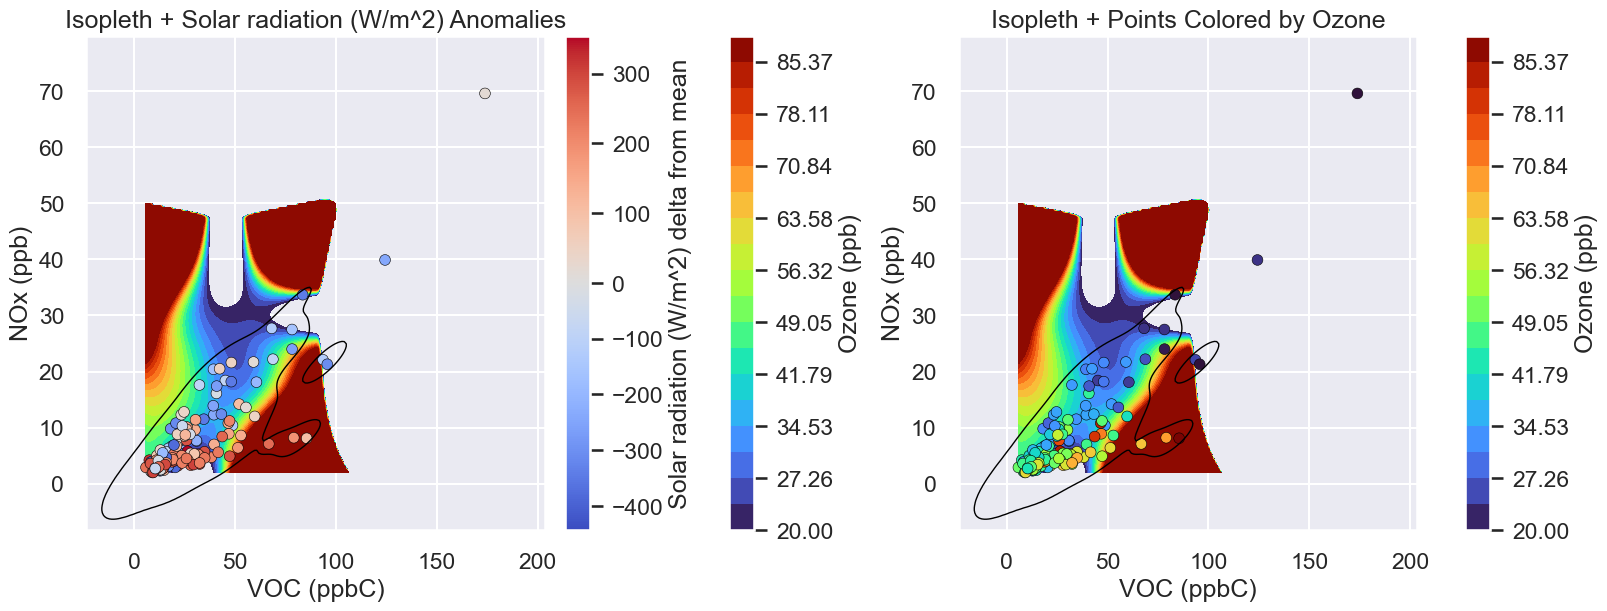

In [14]:

def plot_isopleth_with_radiation(data: pd.DataFrame, config: dict) -> None:
    value_col = config['value_col']
    delta_col = config['delta_col']
    display_name = config['display_name']

    required_cols = ['VOC', 'NOx', 'Ozone', value_col, delta_col]
    subset = data.dropna(subset=required_cols).copy()
    if subset.empty:
        raise ValueError(f'No rows with complete data for the selected radiation metric ({display_name}).')

    x = subset['VOC'].astype(float)
    y = subset['NOx'].astype(float)
    z = subset['Ozone'].astype(float)
    delta = subset[delta_col].astype(float)

    knot_x = np.linspace(x.min(), x.max(), 4)[1:-1]
    knot_y = np.linspace(y.min(), y.max(), 3)[1:-1]

    print(f'[INFO] Knots: {knot_x}, {knot_y}')

    spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)

    grid_x = np.linspace(x.min(), x.max(), 200)
    grid_y = np.linspace(y.min(), y.max(), 200)
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = spline(grid_x, grid_y)
    ozone_max = z.max()
    ozone_min = z.min()
    Z = np.clip(Z, None, ozone_max)
    contour_levels = np.linspace(ozone_min, ozone_max, 20)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    contour0 = axes[0].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    fig.colorbar(contour0, ax=axes[0], pad=0.08, label='Ozone (ppb)')

    norm_delta = TwoSlopeNorm(vmin=delta.min(), vcenter=0, vmax=delta.max())
    scatter0 = axes[0].scatter(
        x, y, c=delta, cmap='coolwarm', norm=norm_delta,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(scatter0, ax=axes[0], pad=0.02,
                 label=f'{display_name} delta from mean')

    sns.kdeplot(data=subset, x='VOC', y='NOx', ax=axes[0], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[0].set_xlabel('VOC (ppbC)')
    axes[0].set_ylabel('NOx (ppb)')
    axes[0].set_title(f'Isopleth + {display_name} Anomalies')

    contour1 = axes[1].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    scatter1 = axes[1].scatter(
        x, y, c=z, cmap='turbo', vmin=ozone_min, vmax=ozone_max,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(contour1, ax=axes[1], pad=0.08, label='Ozone (ppb)')

    sns.kdeplot(data=subset, x='VOC', y='NOx', ax=axes[1], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[1].set_xlabel('VOC (ppbC)')
    axes[1].set_ylabel('NOx (ppb)')
    axes[1].set_title('Isopleth + Points Colored by Ozone')

    plt.show()

plot_isopleth_with_radiation(merged_df, ACTIVE_RADIATION_CONFIG)



## 5 ppb VOC/NOx binned distributions

Segment the merged dataset into 5 ppb by 5 ppb VOC/NOx bins and summarize the median ozone and selected radiation metric in each cell. Bins with fewer than three samples are hidden to avoid noisy estimates, and counts for qualifying bins are overlaid on the ozone panel. Additional plots characterize the distribution of ozone and the chosen radiation metric within each occupied bin and compare ozone to that metric for each cell.


[INFO] Bins meeting count threshold: 20 / 44
[INFO] Bins with at least one sample: 28 / 44
[INFO] Total samples represented: 144


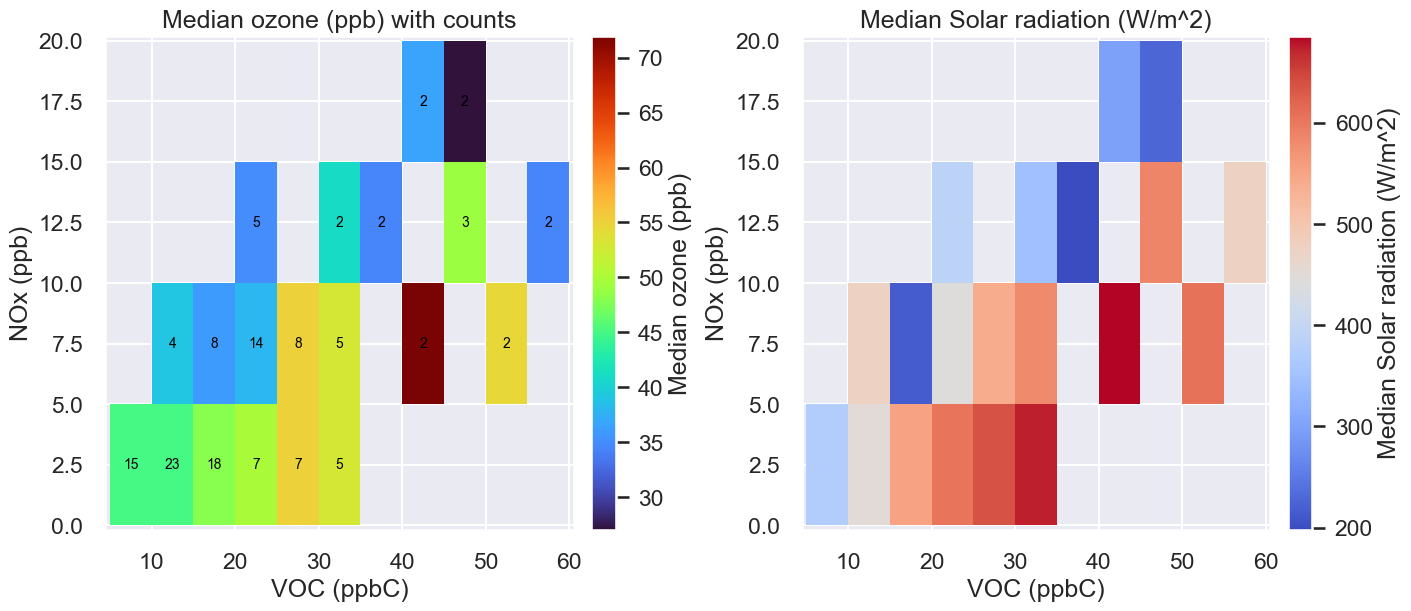

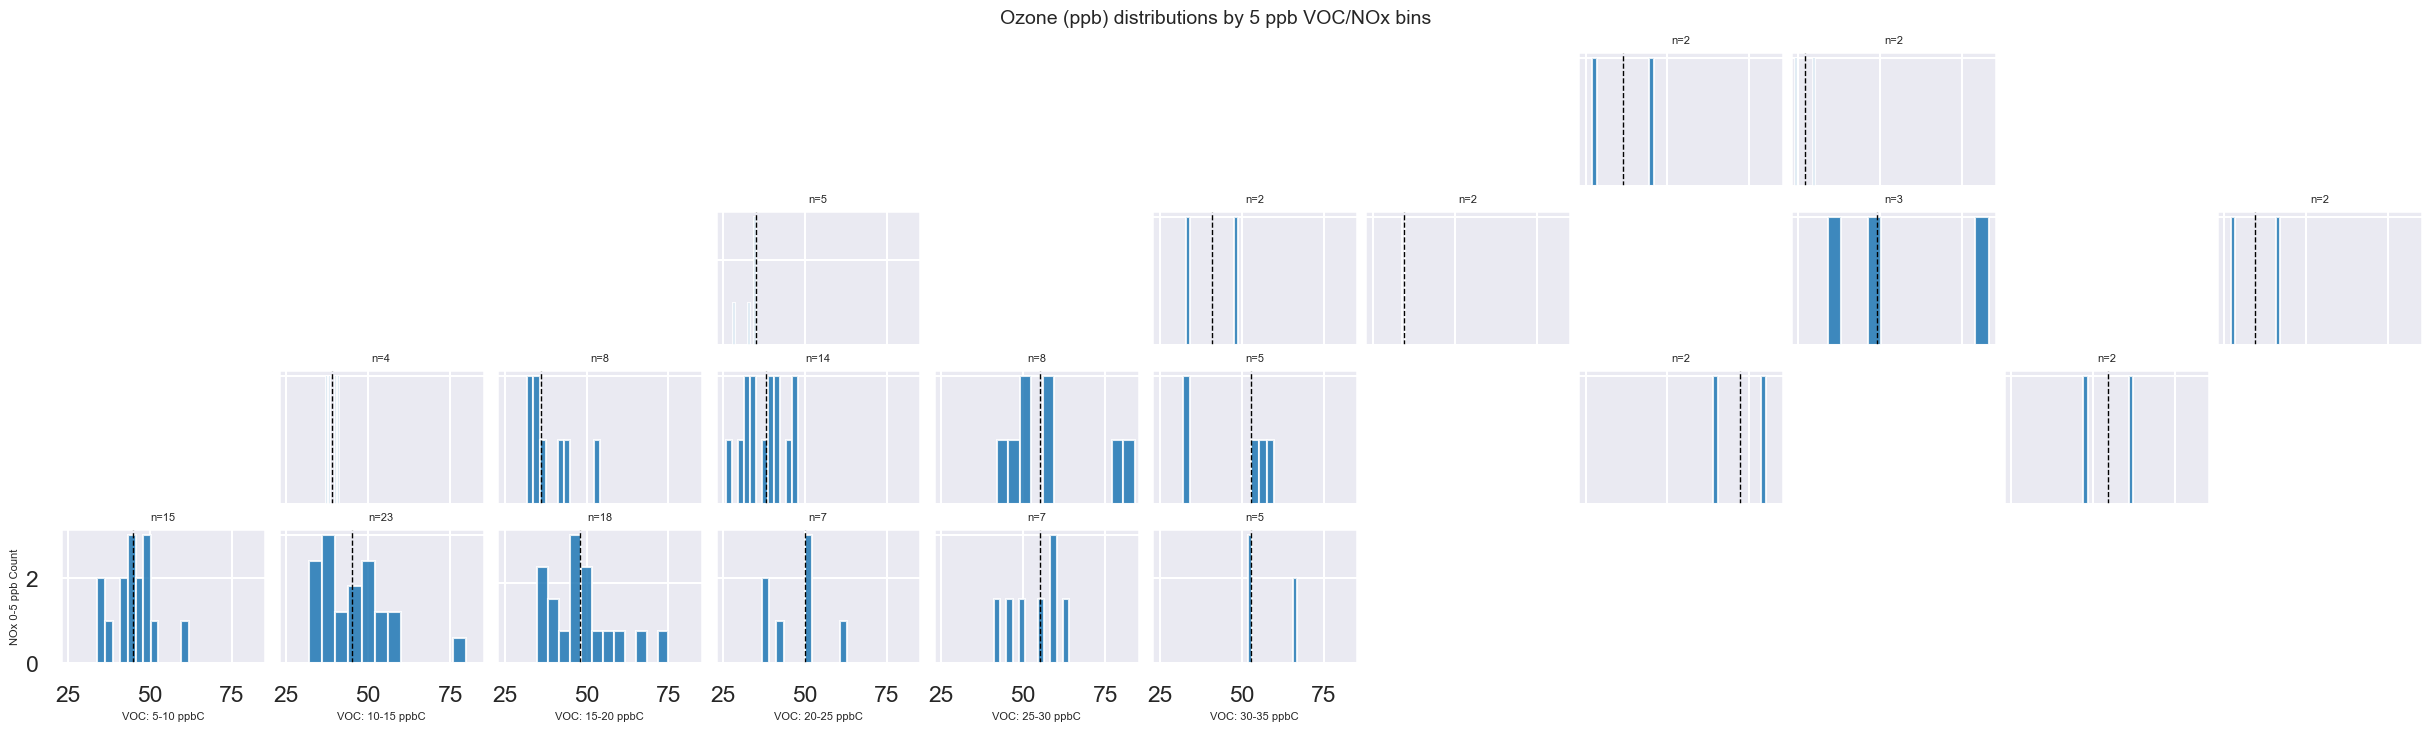

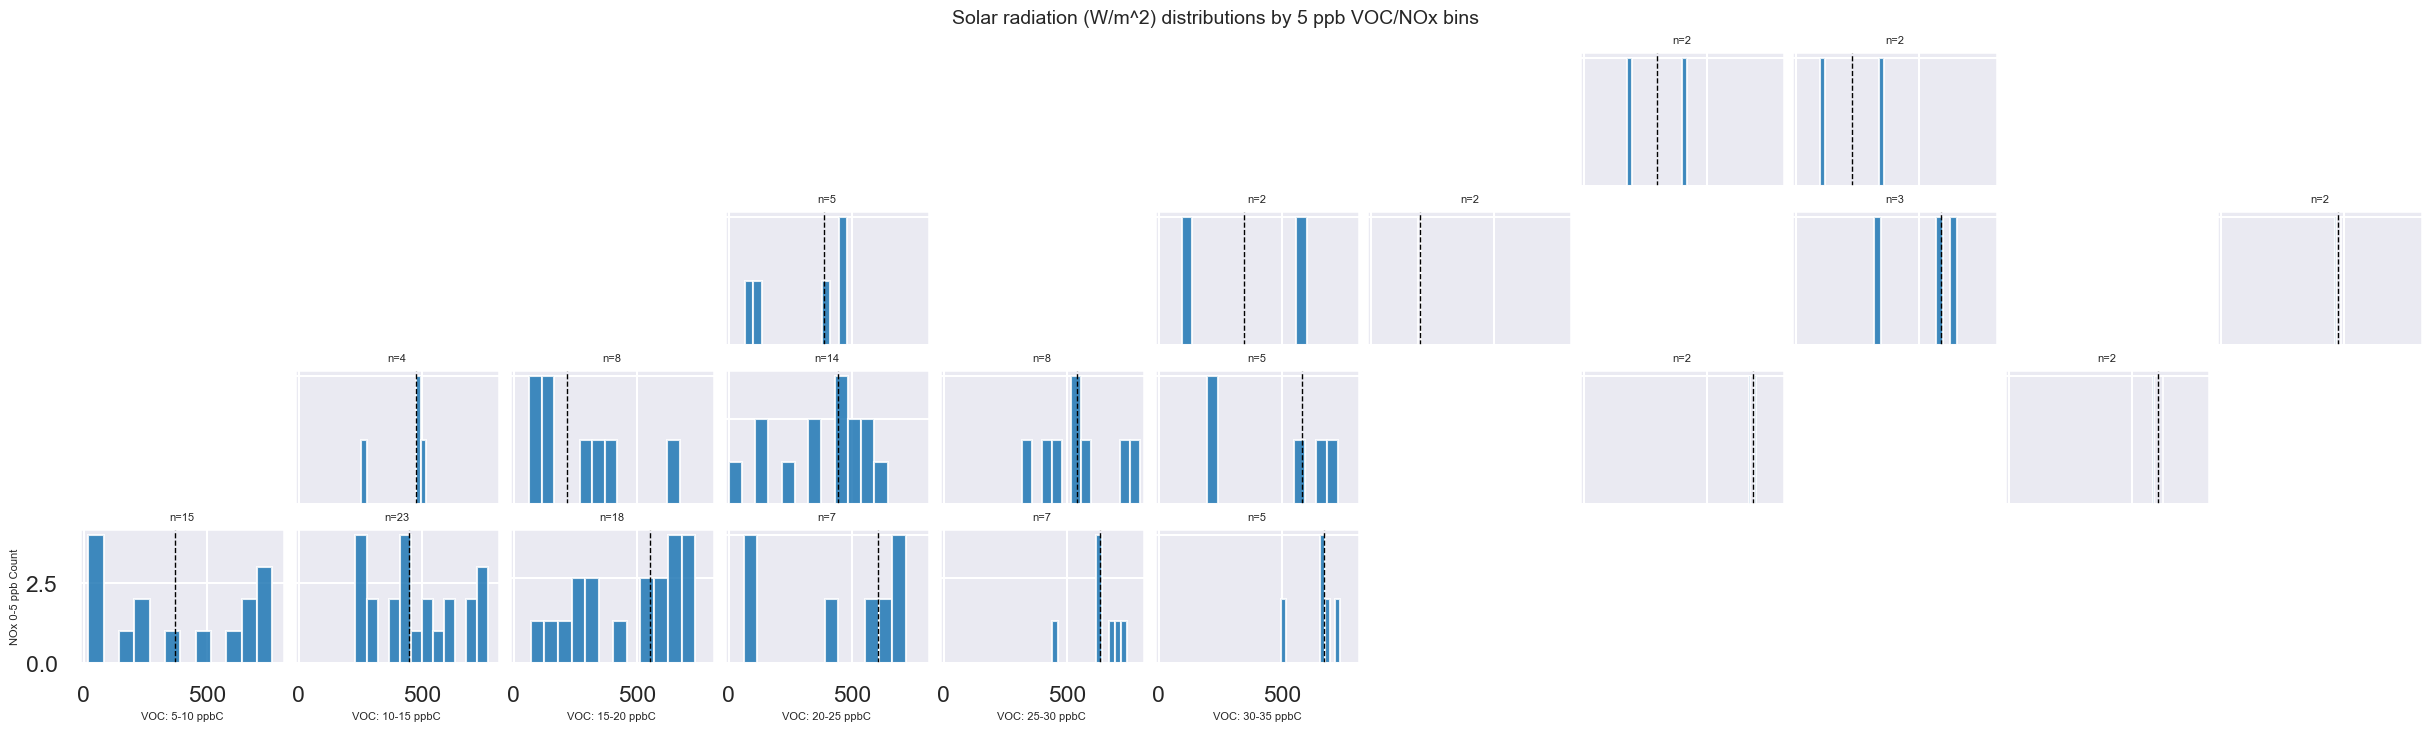

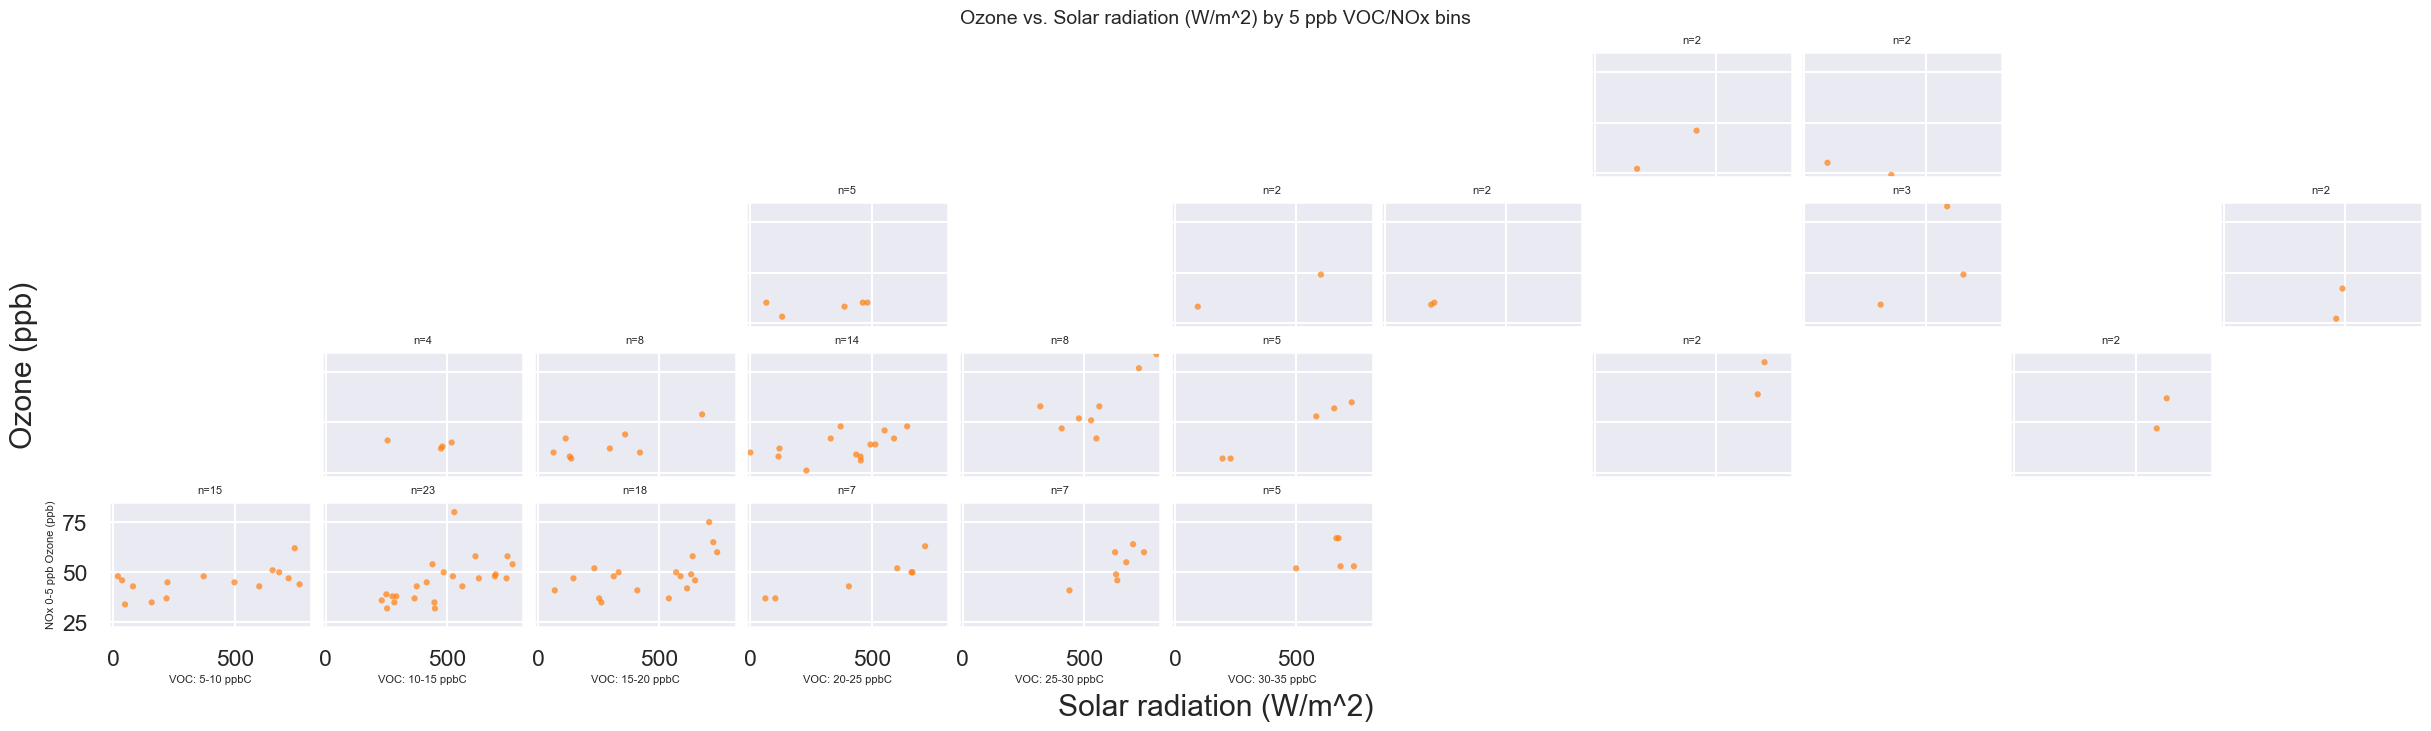

In [16]:

BIN_WIDTH = 5.0
MIN_COUNT = 2

active_radiation = RADIATION_CONFIG[ACTIVE_RADIATION]
value_col = active_radiation['value_col']
display_name = active_radiation['display_name']


def _expand_limits(vmin: float, vmax: float, frac: float = 0.02):
    if np.isclose(vmin, vmax):
        width = abs(vmin) * frac or 1.0
        return vmin - width, vmax + width
    span = vmax - vmin
    pad = span * frac
    return vmin - pad, vmax + pad


def prepare_binned_data(data: pd.DataFrame, bin_width: float = BIN_WIDTH) -> dict:
    required_cols = ['VOC', 'NOx', 'Ozone', value_col]
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Data missing required columns: {missing_cols}")

    filtered = data.dropna(subset=required_cols).copy()
    if filtered.empty:
        raise ValueError('No rows with complete data for the required columns.')

    def make_edges(series: pd.Series) -> np.ndarray:
        start = np.floor(series.min() / bin_width) * bin_width
        stop = np.ceil(series.max() / bin_width) * bin_width
        if start == stop:
            stop += bin_width
        return np.arange(start, stop + bin_width, bin_width)

    voc_edges = make_edges(filtered['VOC'])
    nox_edges = make_edges(filtered['NOx'])

    filtered['VOC_bin'] = pd.cut(filtered['VOC'], bins=voc_edges, include_lowest=True, right=False)
    filtered['NOx_bin'] = pd.cut(filtered['NOx'], bins=nox_edges, include_lowest=True, right=False)

    voc_index = pd.IntervalIndex.from_breaks(voc_edges, closed='left')
    nox_index = pd.IntervalIndex.from_breaks(nox_edges, closed='left')

    binned = filtered.dropna(subset=['VOC_bin', 'NOx_bin'])

    ozone_grid = (
        binned.pivot_table(index='NOx_bin', columns='VOC_bin', values='Ozone', aggfunc='median')
        .reindex(index=nox_index, columns=voc_index)
    )
    radiation_grid = (
        binned.pivot_table(index='NOx_bin', columns='VOC_bin', values=value_col, aggfunc='median')
        .reindex(index=nox_index, columns=voc_index)
    )
    count_grid = (
        binned.pivot_table(index='NOx_bin', columns='VOC_bin', values='Ozone', aggfunc='count')
        .reindex(index=nox_index, columns=voc_index)
        .fillna(0)
    )

    return {
        'filtered': filtered,
        'binned': binned,
        'voc_edges': voc_edges,
        'nox_edges': nox_edges,
        'voc_index': voc_index,
        'nox_index': nox_index,
        'ozone_grid': ozone_grid,
        'radiation_grid': radiation_grid,
        'counts': count_grid,
        'voc_min': filtered['VOC'].min(),
        'voc_max': filtered['VOC'].max(),
        'nox_min': filtered['NOx'].min(),
        'nox_max': filtered['NOx'].max(),
        'ozone_min': filtered['Ozone'].min(),
        'ozone_max': filtered['Ozone'].max(),
        'radiation_min': filtered[value_col].min(),
        'radiation_max': filtered[value_col].max(),
    }


def plot_binned_distributions(data: pd.DataFrame, bin_width: float = BIN_WIDTH, min_count: int = MIN_COUNT) -> dict:
    summary = prepare_binned_data(data, bin_width=bin_width)

    ozone_grid = summary['ozone_grid']
    radiation_grid = summary['radiation_grid']
    count_grid = summary['counts']

    if min_count:
        occupancy_mask = count_grid >= min_count
    else:
        occupancy_mask = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

    if occupancy_mask.any().any():
        row_flags = occupancy_mask.any(axis=1).to_numpy()
        col_flags = occupancy_mask.any(axis=0).to_numpy()
        row_indices = np.flatnonzero(row_flags)
        col_indices = np.flatnonzero(col_flags)
    else:
        row_indices = np.arange(count_grid.shape[0])
        col_indices = np.arange(count_grid.shape[1])

    if row_indices.size == 0 or col_indices.size == 0:
        row_indices = np.arange(count_grid.shape[0])
        col_indices = np.arange(count_grid.shape[1])

    r0, r1 = row_indices[0], row_indices[-1]
    c0, c1 = col_indices[0], col_indices[-1]

    trimmed_ozone = ozone_grid.iloc[r0:r1 + 1, c0:c1 + 1]
    trimmed_radiation = radiation_grid.iloc[r0:r1 + 1, c0:c1 + 1]
    trimmed_counts = count_grid.iloc[r0:r1 + 1, c0:c1 + 1]
    trimmed_mask = occupancy_mask.iloc[r0:r1 + 1, c0:c1 + 1]

    if min_count:
        trimmed_ozone = trimmed_ozone.where(trimmed_mask)
        trimmed_radiation = trimmed_radiation.where(trimmed_mask)

    voc_edges = np.asarray(summary['voc_edges'], dtype=float)
    nox_edges = np.asarray(summary['nox_edges'], dtype=float)
    trimmed_voc_edges = voc_edges[c0:c1 + 2]
    trimmed_nox_edges = nox_edges[r0:r1 + 2]

    plot_voc_min, plot_voc_max = _expand_limits(trimmed_voc_edges[0], trimmed_voc_edges[-1], frac=0.01)
    plot_nox_min, plot_nox_max = _expand_limits(trimmed_nox_edges[0], trimmed_nox_edges[-1], frac=0.01)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    ozone_values = trimmed_ozone.to_numpy(dtype=float)
    if np.isfinite(ozone_values).any():
        vmin = np.nanmin(ozone_values)
        vmax = np.nanmax(ozone_values)
    else:
        raise ValueError('No valid ozone bins available for plotting.')

    mesh_x, mesh_y = np.meshgrid(trimmed_voc_edges, trimmed_nox_edges)
    ozone_plot = axes[0].pcolormesh(mesh_x, mesh_y, trimmed_ozone.to_numpy(dtype=float), cmap='turbo', shading='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(ozone_plot, ax=axes[0], pad=0.02, label='Median ozone (ppb)')
    for (i, j), count in np.ndenumerate(trimmed_counts.to_numpy(dtype=int)):
        if trimmed_mask.iat[i, j]:
            x_center = (trimmed_voc_edges[j] + trimmed_voc_edges[j + 1]) / 2
            y_center = (trimmed_nox_edges[i] + trimmed_nox_edges[i + 1]) / 2
            axes[0].text(x_center, y_center, str(int(count)), ha='center', va='center', color='black', fontsize=10)

    axes[0].set_title('Median ozone (ppb) with counts')
    axes[0].set_xlabel('VOC (ppbC)')
    axes[0].set_ylabel('NOx (ppb)')
    axes[0].set_xlim(plot_voc_min, plot_voc_max)
    axes[0].set_ylim(plot_nox_min, plot_nox_max)

    radiation_plot = axes[1].pcolormesh(mesh_x, mesh_y, trimmed_radiation.to_numpy(dtype=float), cmap='coolwarm', shading='auto')
    fig.colorbar(radiation_plot, ax=axes[1], pad=0.02, label=f'Median {display_name}')
    axes[1].set_title(f'Median {display_name}')
    axes[1].set_xlabel('VOC (ppbC)')
    axes[1].set_ylabel('NOx (ppb)')
    axes[1].set_xlim(plot_voc_min, plot_voc_max)
    axes[1].set_ylim(plot_nox_min, plot_nox_max)

    summary.update({
        'trimmed_voc_edges': trimmed_voc_edges,
        'trimmed_nox_edges': trimmed_nox_edges,
        'trimmed_ozone': trimmed_ozone,
        'trimmed_radiation': trimmed_radiation,
        'trimmed_counts': trimmed_counts,
        'trimmed_mask': trimmed_mask,
    })

    if min_count:
        active_voc_bins = trimmed_ozone.columns
        active_nox_bins = trimmed_ozone.index
        active_filtered = summary['filtered'][
            summary['filtered']['VOC_bin'].isin(active_voc_bins)
            & summary['filtered']['NOx_bin'].isin(active_nox_bins)
        ]

        summary.update({
            'active_voc_bins': active_voc_bins,
            'active_nox_bins': active_nox_bins,
            'active_voc_edges': trimmed_voc_edges,
            'active_nox_edges': trimmed_nox_edges,
            'active_counts': trimmed_counts,
            'active_mask': trimmed_mask,
            'active_filtered': active_filtered,
            'active_ozone_grid': trimmed_ozone,
            'active_radiation_grid': trimmed_radiation,
        })

    return summary


def plot_cell_distributions(summary: dict, variable: str, bins: int = 10, min_count: int = MIN_COUNT) -> None:
    label_map = {
        'Ozone': 'Ozone (ppb)',
        value_col: display_name
    }
    if variable not in label_map:
        raise ValueError(f'Unsupported variable for distribution plots: {variable}')

    binned = summary.get('active_filtered', summary['binned'])
    voc_bins = list(summary.get('active_voc_bins', summary['voc_index']))
    nox_bins = list(summary.get('active_nox_bins', summary['nox_index']))
    if not voc_bins or not nox_bins:
        raise ValueError('No populated bins available for plotting distributions.')

    count_grid = summary.get('active_counts', summary['counts'])
    if min_count:
        qualifying = (count_grid >= min_count)
    else:
        qualifying = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

    active_binned = binned[
        binned['VOC_bin'].isin(voc_bins) & binned['NOx_bin'].isin(nox_bins)
    ]
    if active_binned.empty:
        raise ValueError('No data available in the populated bins to plot distributions.')

    var_min, var_max = _expand_limits(active_binned[variable].min(), active_binned[variable].max(), frac=0.02)

    ncols = len(voc_bins)
    nrows = len(nox_bins)
    fig_width = max(ncols * 2.2, 6)
    fig_height = max(nrows * 1.8, 4)
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), constrained_layout=True)
    axes = np.atleast_2d(axes)

    nox_order = list(reversed(nox_bins))
    voc_order = list(voc_bins)

    for row_idx, nox_interval in enumerate(nox_order):
        for col_idx, voc_interval in enumerate(voc_order):
            ax = axes[row_idx, col_idx]
            if not qualifying.loc[nox_interval, voc_interval]:
                ax.set_axis_off()
                continue

            subset = active_binned[
                (active_binned['NOx_bin'] == nox_interval)
                & (active_binned['VOC_bin'] == voc_interval)
            ]
            if subset.empty:
                ax.set_axis_off()
                continue

            ax.hist(subset[variable], bins=bins, color='#1f77b4', alpha=0.85)
            median_val = subset[variable].median()
            ax.axvline(median_val, color='black', linestyle='--', linewidth=1)
            ax.set_xlim(var_min, var_max)
            ax.set_title(f"n={len(subset)}", fontsize=8)

            if row_idx == nrows - 1:
                range_label = f"{voc_interval.left:.0f}-{voc_interval.right:.0f}"
                ax.set_xlabel(f'VOC: {range_label} ppbC', fontsize=8)
            else:
                ax.set_xticklabels([])

            if col_idx == 0:
                range_label = f"{nox_interval.left:.0f}-{nox_interval.right:.0f}"
                ax.set_ylabel(f'NOx {range_label} ppb Count', fontsize=8)
            else:
                ax.set_yticklabels([])

    fig.suptitle(f"{label_map[variable]} distributions by {BIN_WIDTH:.0f} ppb VOC/NOx bins", fontsize=14)
    plt.show()


def plot_cell_ozone_vs_radiation(summary: dict, min_count: int = MIN_COUNT) -> None:
    binned = summary.get('active_filtered', summary['binned'])
    voc_bins = list(summary.get('active_voc_bins', summary['voc_index']))
    nox_bins = list(summary.get('active_nox_bins', summary['nox_index']))
    if not voc_bins or not nox_bins:
        raise ValueError(f'No populated bins available for plotting ozone vs. {display_name}.')

    count_grid = summary.get('active_counts', summary['counts'])
    if min_count:
        qualifying = (count_grid >= min_count)
    else:
        qualifying = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

    active_binned = binned[
        binned['VOC_bin'].isin(voc_bins) & binned['NOx_bin'].isin(nox_bins)
    ]
    if active_binned.empty:
        raise ValueError(f'No data available in the populated bins to plot ozone vs. {display_name}.')

    rad_min, rad_max = _expand_limits(active_binned[value_col].min(), active_binned[value_col].max(), frac=0.02)
    ozone_min, ozone_max = _expand_limits(active_binned['Ozone'].min(), active_binned['Ozone'].max(), frac=0.02)

    ncols = len(voc_bins)
    nrows = len(nox_bins)
    fig_width = max(ncols * 2.2, 6)
    fig_height = max(nrows * 1.8, 4)
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_2d(axes)

    nox_order = list(reversed(nox_bins))
    voc_order = list(voc_bins)

    for row_idx, nox_interval in enumerate(nox_order):
        for col_idx, voc_interval in enumerate(voc_order):
            ax = axes[row_idx, col_idx]
            if not qualifying.loc[nox_interval, voc_interval]:
                ax.set_axis_off()
                continue

            subset = active_binned[
                (active_binned['NOx_bin'] == nox_interval)
                & (active_binned['VOC_bin'] == voc_interval)
            ]
            if subset.empty:
                ax.set_axis_off()
                continue

            ax.scatter(
                subset[value_col],
                subset['Ozone'],
                s=20,
                alpha=0.7,
                color='#ff7f0e',
                edgecolors='none'
            )
            ax.set_xlim(rad_min, rad_max)
            ax.set_ylim(ozone_min, ozone_max)
            ax.set_title(f"n={len(subset)}", fontsize=8)

            if row_idx == nrows - 1:
                range_label = f"{voc_interval.left:.0f}-{voc_interval.right:.0f}"
                ax.set_xlabel(f'VOC: {range_label} ppbC', fontsize=8)
            if col_idx == 0:
                range_label = f"{nox_interval.left:.0f}-{nox_interval.right:.0f}"
                ax.set_ylabel(f'NOx {range_label} ppb Ozone (ppb)', fontsize=8)

    fig.suptitle(f'Ozone vs. {display_name} by {BIN_WIDTH:.0f} ppb VOC/NOx bins', fontsize=14)
    fig.supxlabel(display_name)
    fig.supylabel('Ozone (ppb)')
    plt.show()


binned_summary = plot_binned_distributions(merged_df, bin_width=BIN_WIDTH, min_count=MIN_COUNT)
occupied_bins = int((binned_summary['active_counts'] >= MIN_COUNT).sum().sum())
non_empty_bins = int((binned_summary['active_counts'] > 0).sum().sum())
total_bins = binned_summary['active_counts'].size
total_samples = int(binned_summary['active_counts'].to_numpy().sum())
print(f'[INFO] Bins meeting count threshold: {occupied_bins} / {total_bins}')
print(f'[INFO] Bins with at least one sample: {non_empty_bins} / {total_bins}')
print(f'[INFO] Total samples represented: {total_samples}')

plot_cell_distributions(binned_summary, variable='Ozone', bins=12, min_count=MIN_COUNT)
plot_cell_distributions(binned_summary, variable=value_col, bins=12, min_count=MIN_COUNT)
plot_cell_ozone_vs_radiation(binned_summary, min_count=MIN_COUNT)
